In [1]:
using DrWatson
@quickactivate "BNP2"
using Turing, Revise, BNP2

;

┌ Info: Precompiling BNP2 [11504357-4fe5-5405-981c-8cd43ea31635]
└ @ Base loading.jl:1273


In [2]:
args = (
    dt        = 0.1,
    inference = :nuts,
)
@assert args.inference in [:pg, :nuts]

if args.inference == :pg
    alg = PG(10)
end
if args.inference == :nuts
    alg = NUTS(100, 0.65)
end
n_samples = 200

const sim = SimpleSimulator(args.dt)
const sim005 = SimpleSimulator(0.05)

;

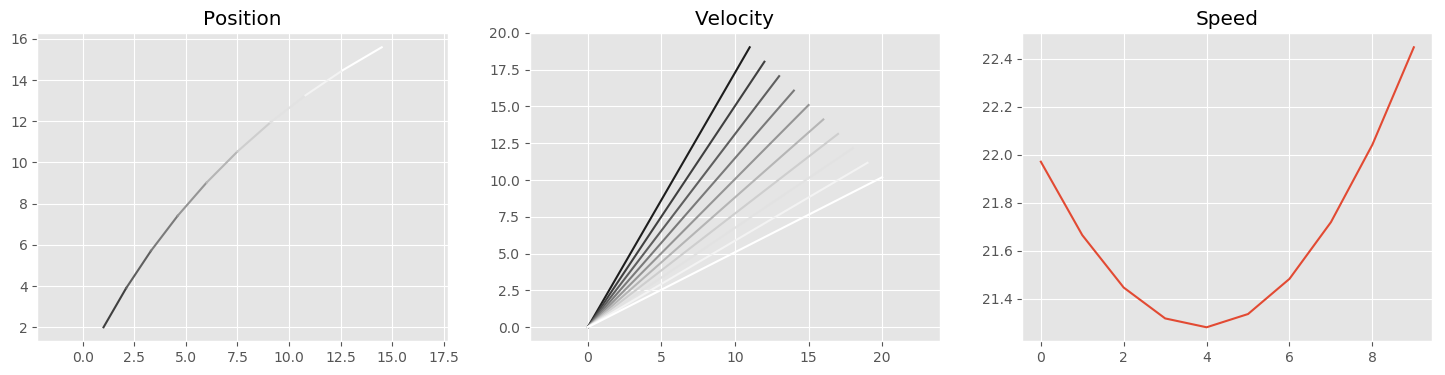

In [3]:
obj_data = Particle(1.0, [0.0, 0.0], [10.0, 20.0])
env_data = EarthWithForce(Force([10.0, 0.0]))
traj_data = simulate(obj_data, env_data, PymunkSimulator(args.dt), 10)
plot(traj_data) |> first |> display

;

## Single force

In [4]:
@model single_force(obj₀, pos_list, vel_list) = begin
    obj = obj₀
    F ~ MvNormal(zeros(2), 10 * ones(2))
    for i in 1:length(pos_list)
        obj′ = transition(obj, EarthWithForce(Force(F)), sim)
        pos_list[i] ~ MvNormal(positionof(obj′), 0.1)
        vel_list[i] ~ MvNormal(velocityof(obj′), 0.1)
        obj = obj′
    end
end

chn = sample(single_force(obj_data, positionof.(traj_data), velocityof.(traj_data)), alg, n_samples; progress_style=:plain)

chn |> display

;

Object of type Chains, with data of type 100×14×1 Array{Real,3}

Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = F[1], F[2]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se     mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ───────  ────────  ──────
        F[1]  9.8337  0.0437    0.0044  missing  115.9276  0.9972
        F[2]  0.1648  0.0468    0.0047  missing  124.4479  0.9905

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
        F[1]  9.7694  9.7899  9.8343  9.8619  9.9105
        F[2]  0.0850  0.1328  0.1617  0.1953  0.2601


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/kai/.julia/packages/Turing/MoqTc/src/inference/hmc.jl:553


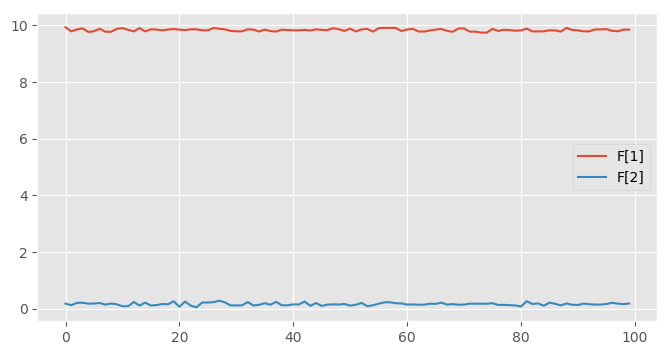

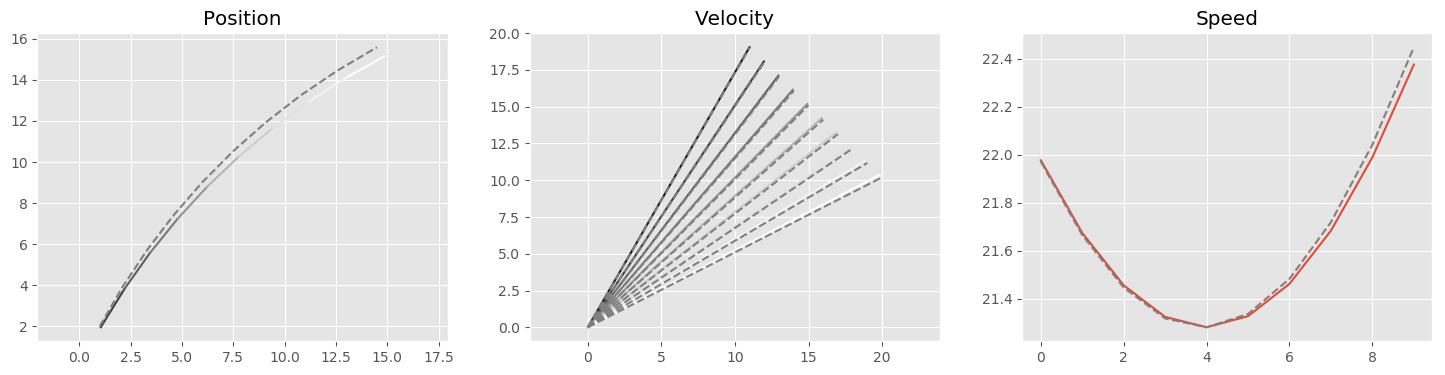

In [5]:
function meantraj(traj_list)
    pos = mean(t.pos for t in traj_list)
    vel = mean(t.vel for t in traj_list)
    return Particle.(1.0, pos, vel)
end

function stdtrajdev(traj_list)
    pos = mean(t.pos for t in traj_list)
    dev = []
    for t in 1:length(pos)
        ps = [traj_list[i].pos[t] for i in 1:length(traj_list)]
        push!(dev, 2 * sqrt(sum(std(ps).^2)))
    end
    return dev
end

function updatedev!(ax, traj_list)
    traj = meantraj(traj_list)
    dev = stdtrajdev(traj_list)
    for t in 1:length(traj)
        c = plt.Circle(tuple(positionof(traj[t])...), dev[t], color="gray", alpha=0.25)
        ax.add_artist(c)
    end
end

let res = get(chn, :F)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(res.F[1], label="F[1]")
    ax.plot(res.F[2], label="F[2]")
    ax.legend()
    fig |> display
end

let res = get(chn[end-99:end], [:F])
    traj_list = []
    for i in 1:100
        F = [res.F[1][i], res.F[2][i]]
        traj = simulate(obj_data, EarthWithForce(Force(F)), sim, 10)
        push!(traj_list, (pos=positionof.(traj), vel=velocityof.(traj)))
    end
    fig, axes = plot(meantraj(traj_list), traj_data)
    updatedev!(first(axes), traj_list)
    display(fig)
end

;

## Single force and particle parameters

In [6]:
@model single_force_all_params(pos_list, vel_list) = begin
    F ~ MvNormal(zeros(2), 10 * ones(2))
    mass ~ InverseGamma(2, 3)
    pos₀ ~ MvNormal(zeros(2), 10 * ones(2))
    vel₀ ~ MvNormal(zeros(2), 10 * ones(2))
    obj = Particle(mass, pos₀, vel₀)
    for i in 1:length(pos_list)
        obj′ = transition(obj, EarthWithForce(Force(F)), SimpleSimulator(args.dt))
        pos_list[i] ~ MvNormal(positionof(obj′), 0.1)
        vel_list[i] ~ MvNormal(velocityof(obj′), 0.1)
        obj = obj′
    end
end

chn = sample(single_force_all_params(positionof.(traj_data), velocityof.(traj_data)), alg, n_samples; progress_style=:plain)

chn |> display

;

Object of type Chains, with data of type 100×19×1 Array{Real,3}

Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = F[1], F[2], mass, pos₀[1], pos₀[2], vel₀[1], vel₀[2]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean     std  naive_se     mcse       ess   r_hat
  ──────────  ───────  ──────  ────────  ───────  ────────  ──────
        F[1]  14.1319  4.8309    0.4831  missing    3.2069  1.5442
        F[2]   0.0148  0.1347    0.0135  missing   56.7515  0.9901
        mass   1.4150  0.4827    0.0483  missing    3.1957  1.5452
     pos₀[1]  -0.2623  0.0354    0.0035  missing   99.1842  1.0114
     pos₀[2]   0.2536  0.0390    0.0039  missing  126.5475  0.9907
     vel₀[1]   9.9744  0.0731    0.0073 

┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /Users/kai/.julia/packages/Turing/MoqTc/src/inference/hmc.jl:553


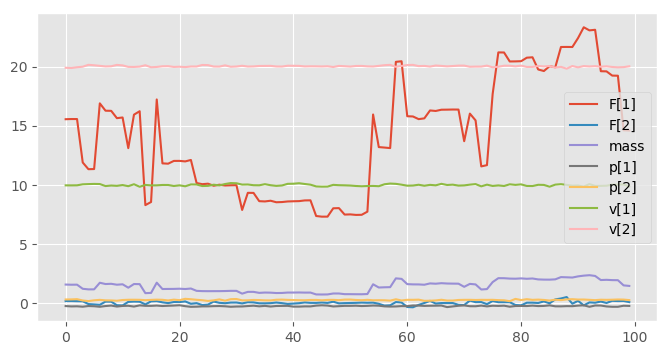

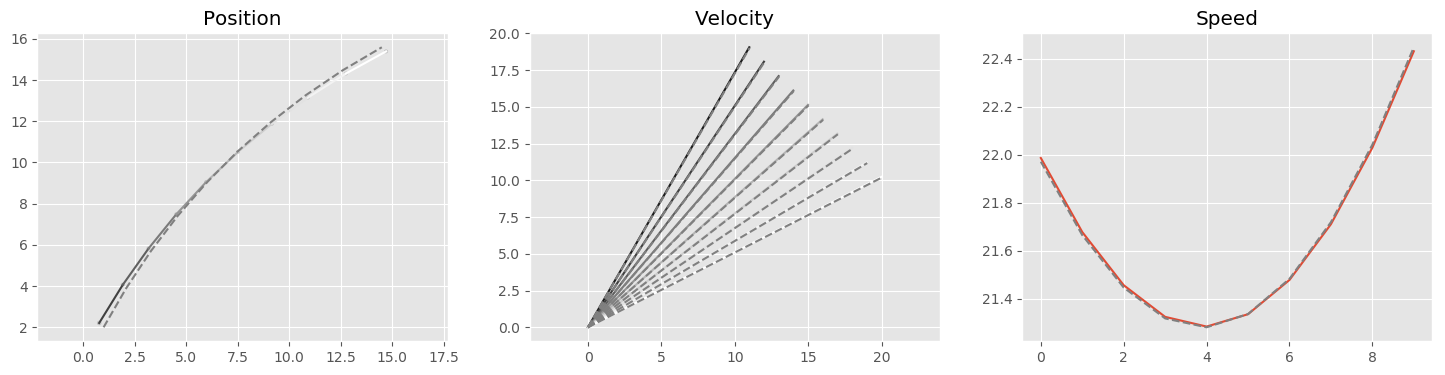

In [7]:
let res = get(chn, [:F, :mass, :pos₀, :vel₀])
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(res.F[1], label="F[1]")
    ax.plot(res.F[2], label="F[2]")
    ax.plot(res.mass, label="mass")
    ax.plot(res.pos₀[1], label="p[1]")
    ax.plot(res.pos₀[2], label="p[2]")
    ax.plot(res.vel₀[1], label="v[1]")
    ax.plot(res.vel₀[2], label="v[2]")
    ax.legend()
    fig |> display
end

let res = get(chn[end-99:end], [:F, :mass, :pos₀, :vel₀])
    traj_list = []
    for i in 1:100
        F = [res.F[1][i], res.F[2][i]]
        mass = res.mass[i]
        pos₀ = [res.pos₀[1][i], res.pos₀[2][i]]
        vel₀ = [res.vel₀[1][i], res.vel₀[2][i]]
        traj = simulate(Particle(mass, pos₀, vel₀), EarthWithForce(Force(F)), sim, 10)
        push!(traj_list, (pos=positionof.(traj), vel=velocityof.(traj)))
    end
    fig, axes = plot(meantraj(traj_list), traj_data)
    updatedev!(first(axes), traj_list)
    display(fig)
end

;

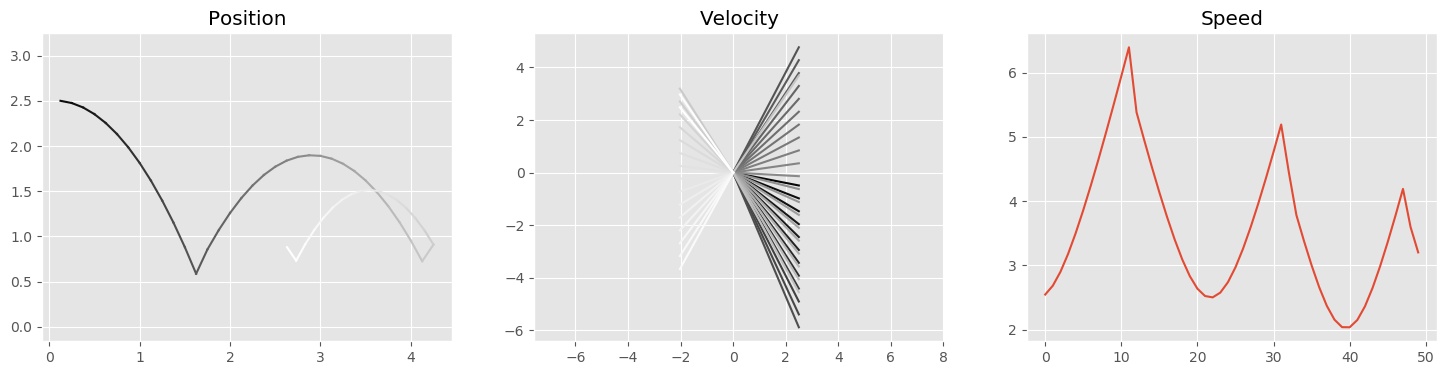

In [8]:
traj_obstacle = simulate(
    Particle(1.0, [0.0, 2.5], [2.5, 0.0]), 
    EarthWithObjects([Bar((-20.0, 0.0), (20.0, 0.0)), Bar((5.0, -20.0), (5.0, 20.0))]),
    PymunkSimulator(0.05),
    50,
)

plot(traj_obstacle) |> first |> display

## Each force for each time step

In [9]:
@model multiple_time_depedent_forces(pos_list, vel_list, ::Type{R}=Float64) where {R} = begin
    obj = Particle(1.0, [0.0, 2.5], [2.5, 0.0])
    T = length(pos_list)
    F = Vector{Vector{R}}(undef, T)
    for t in 1:T
        F[t] ~ MvNormal(zeros(2), 10 * ones(2))
        obj′ = transition(obj, EarthWithForce(Force(F[t])), sim005)
        pos_list[t] ~ MvNormal(positionof(obj′), 0.1)
        vel_list[t] ~ MvNormal(velocityof(obj′), 0.1)
        obj = obj′
    end
end

chn = sample(multiple_time_depedent_forces(positionof.(traj_obstacle), velocityof.(traj_obstacle)), alg, n_samples; progress_style=:plain)

chn |> display

;

Object of type Chains, with data of type 100×112×1 Array{Real,3}

Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = F[1][1], F[1][2], F[2][1], F[2][2], F[3][1], F[3][2], F[4][1], F[4][2], F[5][1], F[5][2], F[6][1], F[6][2], F[7][1], F[7][2], F[8][1], F[8][2], F[9][1], F[9][2], F[10][1], F[10][2], F[11][1], F[11][2], F[12][1], F[12][2], F[13][1], F[13][2], F[14][1], F[14][2], F[15][1], F[15][2], F[16][1], F[16][2], F[17][1], F[17][2], F[18][1], F[18][2], F[19][1], F[19][2], F[20][1], F[20][2], F[21][1], F[21][2], F[22][1], F[22][2], F[23][1], F[23][2], F[24][1], F[24][2], F[25][1], F[25][2], F[26][1], F[26][2], F[27][1], F[27][2], F[28][1], F[28][2], F[29][1], F[29][2], F[30][1], F[30][2], F[31][1], F[31][2], F[32][1], F[32

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/kai/.julia/packages/Turing/MoqTc/src/inference/hmc.jl:553


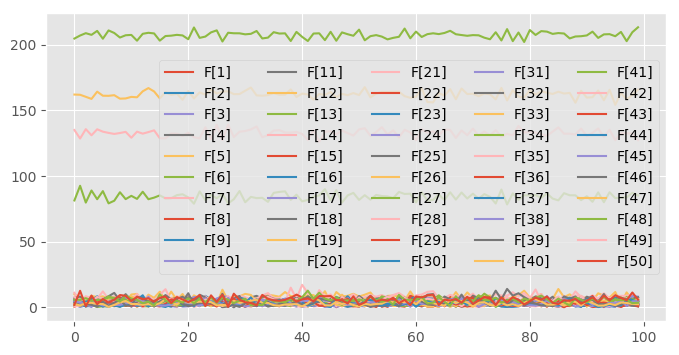

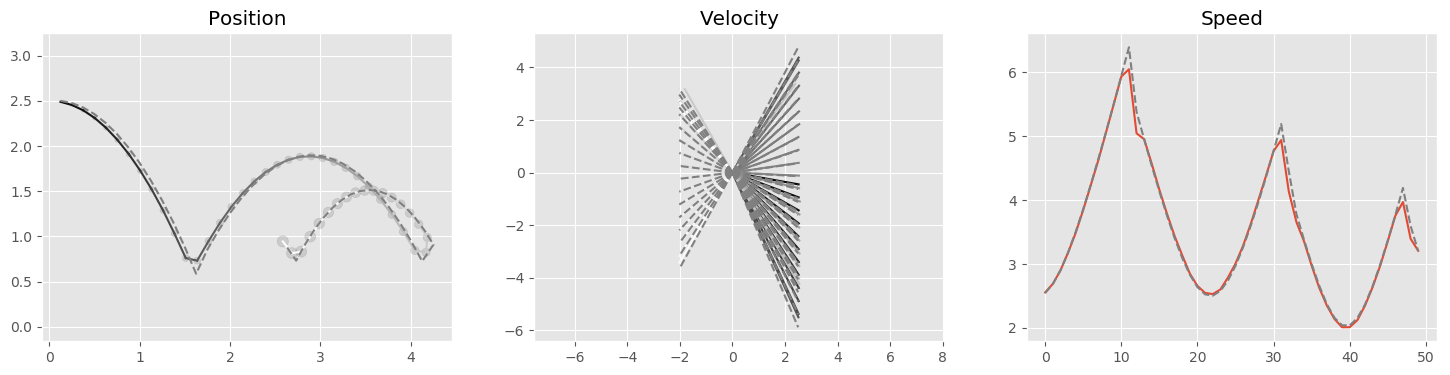

In [10]:
let fig = plt.figure(figsize=(8, 4))
    for i in 1:length(traj_obstacle)
        Fs = sqrt.(get(chn, Symbol("F[$i][1]"))[1].^2 + get(chn, Symbol("F[$i][2]"))[1].^2)
        plt.plot(Fs, label="F[$i]")
    end
    plt.legend(ncol=5)
    fig |> display
end

let n_used = 100, T = length(traj_obstacle)
    traj_list = []
    for i in 1:100
        obj = Particle(1.0, [0.0, 2.5], [2.5, 0.0])
        traj = Vector{typeof(obj)}(undef, T)
        for t in 1:T
            F = let chn_sub = chn[end-n_used+1:end]
                [
                    get(chn_sub, Symbol("F[$t][1]"))[1][i], 
                    get(chn_sub, Symbol("F[$t][2]"))[1][i],
                ]
            end
            obj = transition(obj, EarthWithForce(Force(F)), sim005)
            traj[t] = obj
        end
        push!(traj_list, (pos=positionof.(traj), vel=velocityof.(traj)))
    end
    fig, axes = plot(meantraj(traj_list), traj_obstacle)
    updatedev!(first(axes), traj_list)
    display(fig)
end

;